# Introduction 

This report investigates the sales funnel of our app users. We would like to find out at what stage users churn most frequently and whether we can increase overall conversion by introducing altered fonts on our app. 

# 1 Open the data file and read the general information

In [69]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sys 
import warnings
import datetime as dt 
from datetime import timedelta 
from datetime import datetime

if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
    
try:
    logs= pd.read_csv('logs_exp_us.csv', sep= '\t')
    
except:
    logs= pd.read_csv('/datasets/logs_exp_us.csv',sep= '\t')
    
display(logs.head(5))
display(logs.tail(5))
display(logs.info())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


,EventName,DeviceIDHash,EventTimestamp,ExpId
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246
244125,OffersScreenAppear,5746969938801999050,1565212517,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

All necessary columns are in the dataset and we have no NAs. In the next part, I'm going to change the timestamp to datetime and check the data for dupplicate entries. 

# 2 Prepare the data for analysis

In [70]:
logs.columns= ['event_name', 'device_id_hash','event_timestamp',\
             'exp_id']

logs.exp_id= logs.exp_id.astype('int16')

logs['date_and_time']= pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date']= logs['date_and_time'].dt.date

logs.info()
logs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244126 non-null  object        
 1   device_id_hash   244126 non-null  int64         
 2   event_timestamp  244126 non-null  int64         
 3   exp_id           244126 non-null  int16         
 4   date_and_time    244126 non-null  datetime64[ns]
 5   date             244126 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(2), object(2)
memory usage: 9.8+ MB


,event_name,device_id_hash,event_timestamp,exp_id,date_and_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [71]:
print(len(logs[logs.duplicated()]))

logs= logs.drop_duplicates()

logs.info()

413
<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int16         
 4   date_and_time    243713 non-null  datetime64[ns]
 5   date             243713 non-null  object        
dtypes: datetime64[ns](1), int16(1), int64(2), object(2)
memory usage: 11.6+ MB


We have 413 duplicates in the dataset. This might be due to connection problems which led to the double logging of users. Whatever the reason may be, I dropped them from the data and continue with the reduced data. 

# 3 Study and check the data

#### How many events are in the logs?

In [72]:
number_before= len(logs)
number_before

243713

We can see, there's a total of 243713 events. 

#### How many users are in the logs? 

In [73]:
number_of_users= logs.pivot_table(columns= 'exp_id', values= 'device_id_hash', aggfunc= 'nunique')
number_of_users['total']= number_of_users.sum(axis=1)
number_of_users

exp_id,246,247,248,total
device_id_hash,2489,2520,2542,7551


We have a total of 7551 users which are quite evenly spread across the test groups. 

#### Average number of events per user

In [74]:
pd.DataFrame(logs.groupby('device_id_hash')['event_name'].count().describe())

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


In terms of mean, one user performed 32.28 events on average. In terms of median, this number is at 20 events. 

#### What period of time does the data cover? Find the maximum and the minimum date. Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

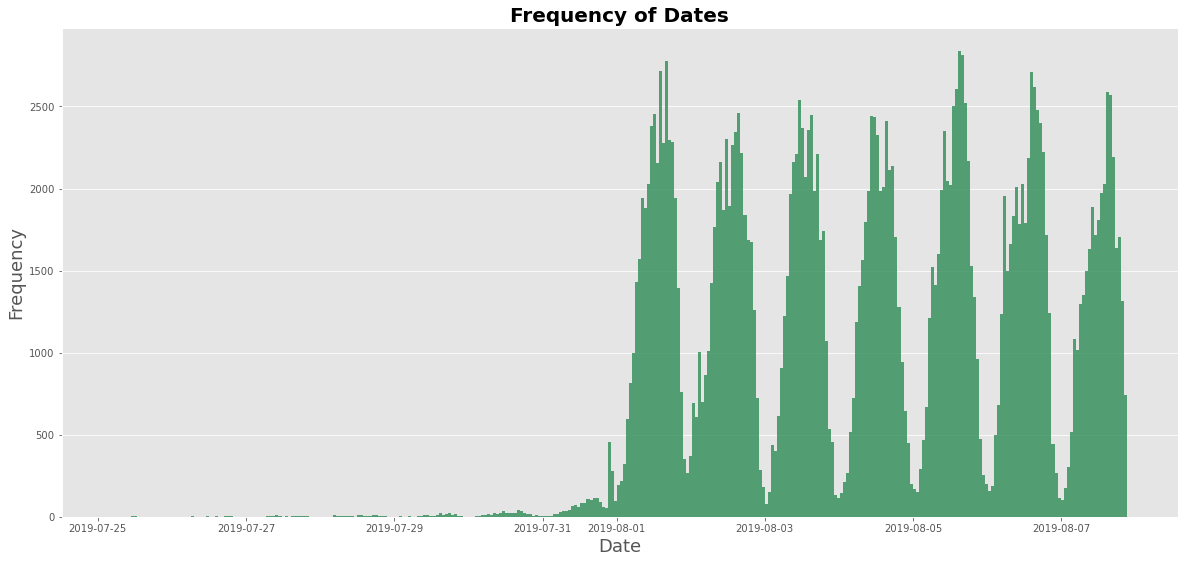

In [75]:
fig, ax= plt.subplots(figsize= (20,9))
plt.style.use('ggplot')
ax.hist(logs.date_and_time, color= 'seagreen', bins= 336, alpha= 0.8)
ax.set_title('Frequency of Dates', size= 20, fontweight= 'bold')
ax.set_ylabel('Frequency', size= 18)
ax.set_xlabel('Date', size= 18)
ax.xaxis.grid()
plt.show()

We can see that the logging started at 25 July 2019 and ended at the 7 August 2019. However, the values only start to exhibit a steady periodic pattern by the 1 August. Perhaps some users started to perform their first actions in July already. As such to have a coherent dataset, I will restrict the dataframe to the period 1 - 7 August and remove users who have logs starting before this time period. 

#### Did you lose many events and users when excluding the older data?

In [76]:
cutoff= pd.to_datetime('2019-08-01')
logs_cut= logs.query('date < @cutoff')
logs= logs.query('date>= @cutoff')

number_after= len(logs)

difference= number_before-number_after

difference

2826

We lost 2826 events by reducing the timeperiod.

#### Make sure you have users from all three experimental groups.

In [77]:
pd.DataFrame(logs.pivot_table(columns= 'exp_id', values= 'device_id_hash', aggfunc= 'nunique'))

exp_id,246,247,248
device_id_hash,2484,2513,2537


We didn't lose so many users from each group and thus we can continue the experiment. In a more rigorous setup of the analysis we might have wanted to get rid of all users who performed an action before the 1 August. However, this would have resulted in a loss of data of roughly 25% which is quite a lot. 

# 4 Study the event funnel

#### See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [78]:
logs= logs.reset_index(drop= True)
logs.head()

,event_name,device_id_hash,event_timestamp,exp_id,date_and_time,date
0,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
1,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
3,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
4,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


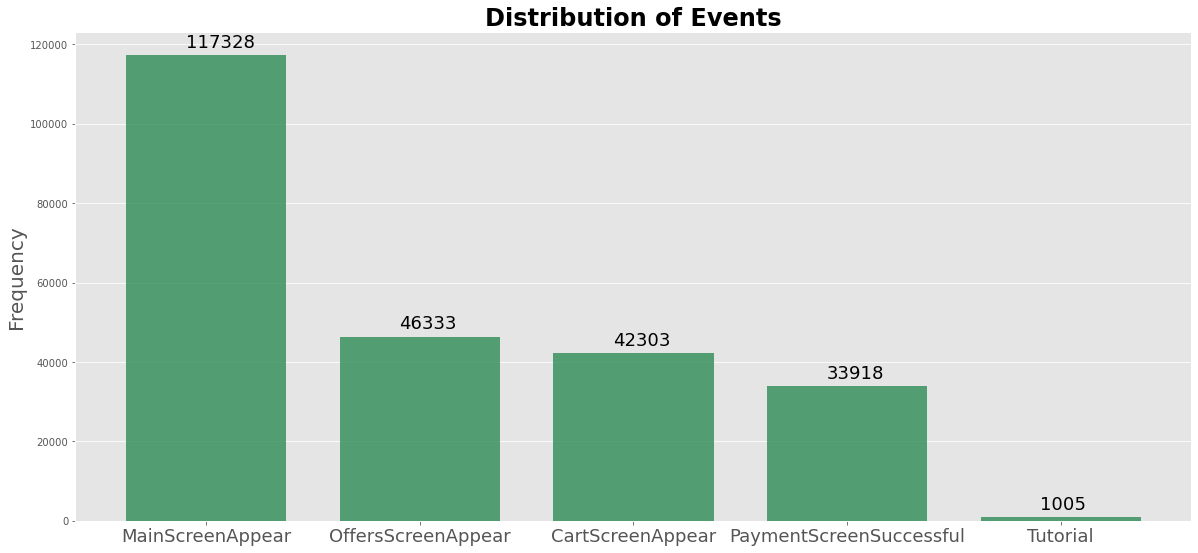

In [99]:
event_occ= pd.DataFrame(logs.event_name.value_counts()).reset_index().\
rename(columns= {'index':'event_name', 'event_name':'count'})
plt.style.use('classic')

labels= event_occ['event_name']
fig, ax= plt.subplots(figsize= (20,9))
bar_plot= ax.bar(event_occ['event_name'], event_occ['count'], width= 0.75, color= 'seagreen', alpha= 0.8)
ax.set_xticks= np.arange(0,5)
for i,rect in enumerate(bar_plot):
    ax.text(rect.get_x()+rect.get_width()/2.7, rect.get_height()+ 2000, rect.get_height(), size= 18)

ax.set_title('Distribution of Events', size= 24, fontweight= 'bold')
ax.set_ylabel('Frequency', size= 20)
ax.set_xticklabels(event_occ['event_name'], size= 18)
ax.xaxis.grid()
plt.show()

We have five different events of which MainScreenAppear occurs most frequently while Tutorial is not used that much. 

#### Find the number of users who performed each of these actions. Sort the events by the number of users. Calculate the proportion of users who performed the action at least once.

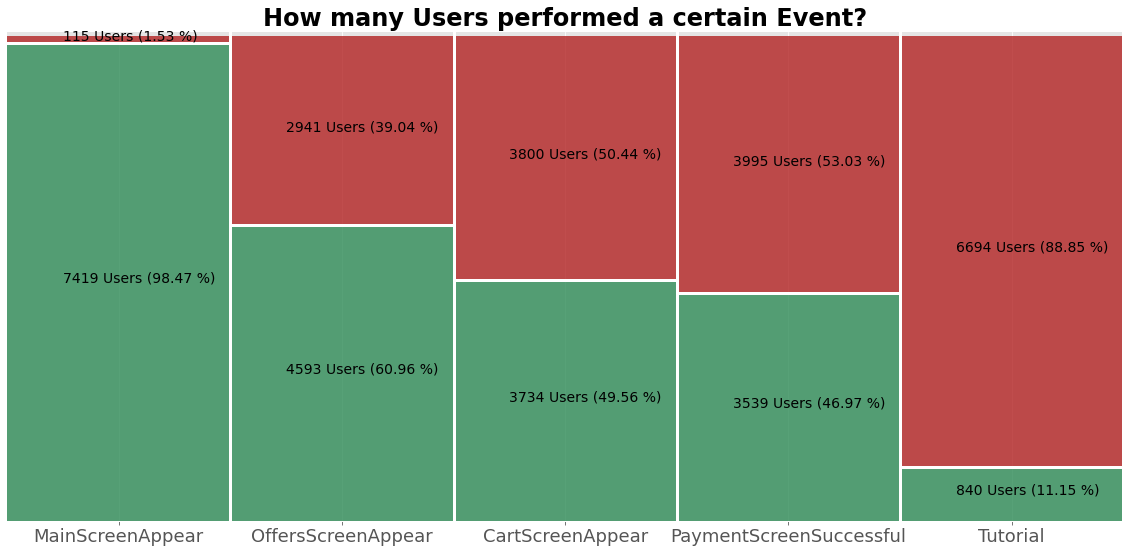

In [96]:
unique_user_events= logs.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values('device_id_hash', ascending= False).reset_index().\
rename(columns= {'device_id_hash':'count'})
user_count= logs.device_id_hash.nunique()

x= np.arange(0,len(unique_user_events))
labels= unique_user_events['event_name']
fig, ax= plt.subplots(figsize= (20,9))
bar_plot= ax.bar(unique_user_events['event_name'], unique_user_events['count'], width= 1, color= 'seagreen', alpha= 0.8)
bar_plot2= ax.bar(unique_user_events['event_name'], user_count-unique_user_events['count'], width= 1, color= 'firebrick', alpha= 0.8, bottom= unique_user_events['count'])
ax.set_xticks= np.arange(0,5)
ax.set_xlim(-0.5,4.5)
ax.set_ylim(0,7600)

for i,p in enumerate(x):
    s= i/len(x)
    ax.axvline(x= p+0.5, ymin=0, ymax=1,linewidth= 3, color= 'white')
    ax.axhline(y= unique_user_events['count'][i],xmin= s, xmax= s+0.2,linewidth=3, color= 'white')

for i,rect in enumerate(bar_plot):
    #ax.text(rect.get_x()+rect.get_width()/3, rect.get_height()/2, s= 'Total :'+str(rect.get_height()), size= 18)
    ax.text(rect.get_x()+rect.get_width()/4, rect.get_height()/2, s=str(rect.get_height())+' Users '+'('+str(np.round(rect.get_height()/user_count*100,2))+ " %)", size= 14)
    
for i,rect in enumerate(bar_plot2):
    ax.text(rect.get_x()+rect.get_width()/4,(rect.get_height()/2)+unique_user_events['count'][i],\
           s= str(rect.get_height())+' Users '+'('+str(np.round((user_count-unique_user_events['count'][i])/user_count*100,2))+' %)', size= 14)
    
ax.set_title('How many Users performed a certain Event?', size= 24, fontweight= 'bold')
ax.set_ylabel('Frequency', size= 20)
ax.set_xticklabels(event_occ['event_name'], size= 18)
right_side = ax.spines["right"]
left_side= ax.spines["left"]
top_side= ax.spines["top"]
right_side.set_visible(False)
left_side.set_visible(False)
top_side.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

While most users opened the main screen there's still 1.53% who didnt end up on this page. Perhaps they accessed the product through a third party, or were otherwise led directly to the product pages. The conversion rate is at 46.97% which is very high. Only 11.15% of visitors watched the tutorial. 

#### In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.

Judging from the frequency of events, I believe the principal funnel follows the ordering of the bar chart above excluding the Tutorial at the end. The next part will calculate the conversion funnel from main page down to payment. 

#### Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

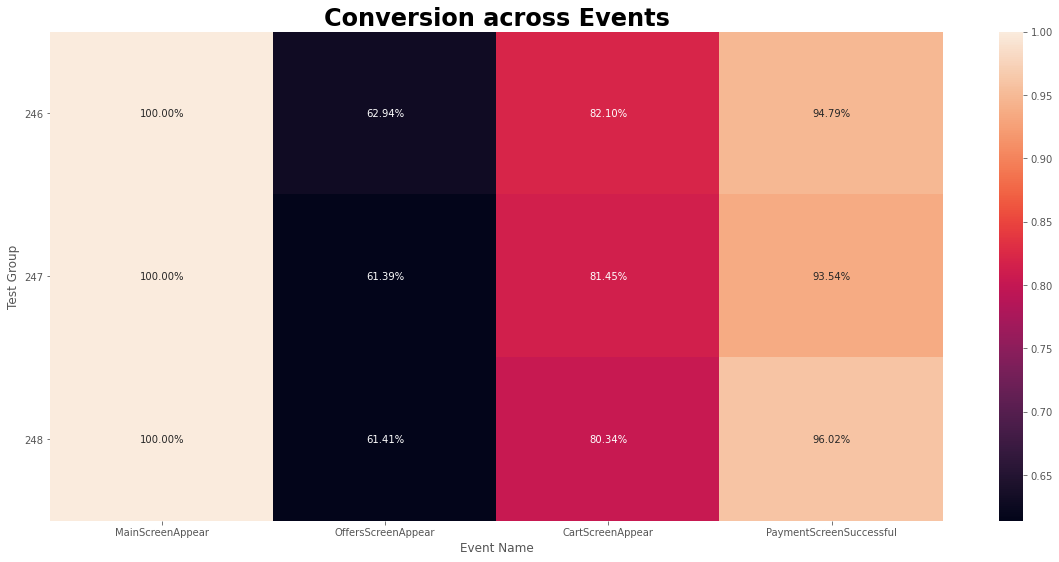

In [100]:
event_funnel= logs.pivot_table(index= 'exp_id',columns= 'event_name', values= 'device_id_hash', aggfunc= 'nunique').\
sort_values(by= 246, axis=1,ascending= False).drop(columns= 'Tutorial')

cols= list(event_funnel.columns)
cols.reverse()

for i,x in enumerate(cols):
    try:
        event_funnel[x]= event_funnel[x]/event_funnel[cols[i+1]]        
    except:
        event_funnel[x]= 1

fig,ax= plt.subplots(figsize= (20,9))
sns.heatmap(event_funnel,annot= True, fmt= '.2%')
ax.set_ylabel('Test Group')
ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
ax.set_xlabel('Event Name')
ax.set_title('Conversion across Events', size= 24, fontweight= 'bold')
plt.show()

The highes dropout rates are between the first two stages. This implies that users are very likely to buy as soon as they see the offers on the page. Beyond the test to be conducted in this analysis, I recommend placing more products on the main screen to increase conversion between these two stages. 

#### What share of users make the entire journey from their first event to payment?

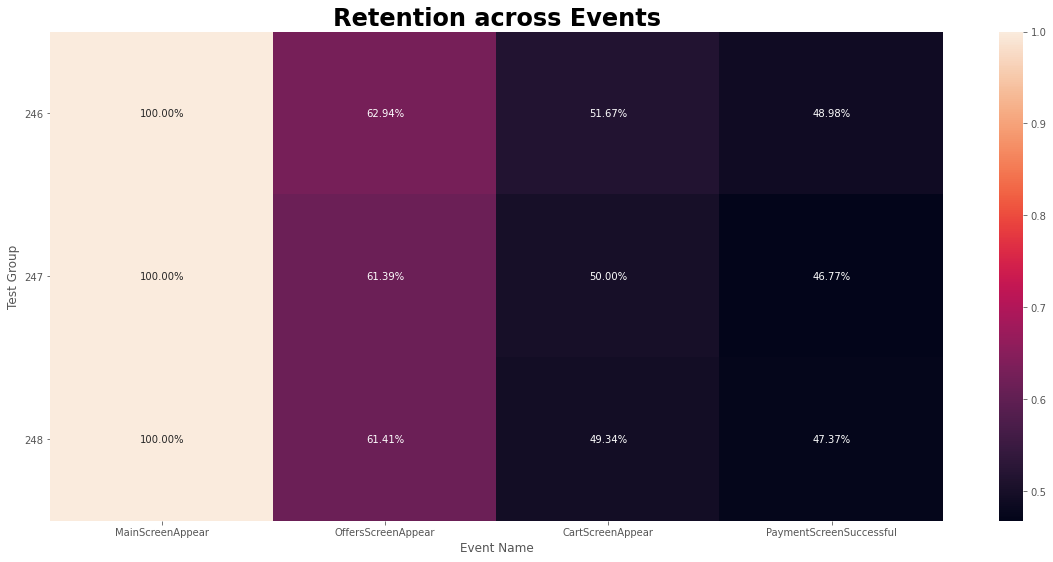

In [102]:
event_funnel= logs.pivot_table(index= 'exp_id',columns= 'event_name', values= 'device_id_hash', aggfunc= 'nunique').\
sort_values(by= 246, axis=1,ascending= False).drop(columns= 'Tutorial')

cols= list(event_funnel.columns)
cols.reverse()

for i,x in enumerate(cols):
    event_funnel[x]= event_funnel[x]/event_funnel['MainScreenAppear']        

fig,ax= plt.subplots(figsize= (20,9))
sns.heatmap(event_funnel,annot= True, fmt= '.2%')
ax.set_ylabel('Test Group')
ax.set_yticklabels(ax.get_yticklabels(), rotation= 0)
ax.set_title('Retention across Events',size= 24, fontweight= 'bold')
ax.set_xlabel('Event Name')
plt.show()

As already shown earlier, 46.97% of all users went through all stages of the funnel and converted to customers. However, this value varies between groups. In the next section, I will investigate whether this difference in conversion is statistically significant. 

# 5 Study the results of the experiment

#### How many users are there in each group?

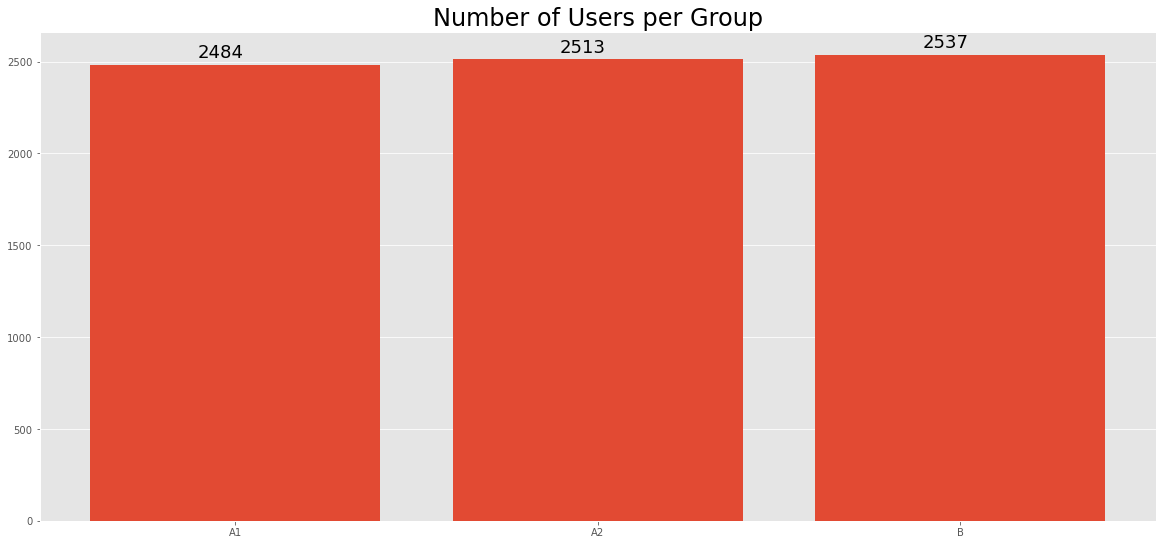

In [115]:
users_per_group= logs.groupby('exp_id').agg({'device_id_hash':'nunique'})

fig, ax= plt.subplots(figsize= (20,9))

labels= ["A1","A2","B"]
bp= ax.bar(users_per_group.index, users_per_group.device_id_hash)
ax.xaxis.grid()
ax.set_title('Number of Users per Group', size= 24)
ax.set_xticks(users_per_group.index)
ax.set_xticklabels(labels)
for i, rect in enumerate(bp):
    ax.text(rect.get_x()+ rect.get_width()/2.7, rect.get_height()+40, rect.get_height(), size= 18)

plt.show()


We have a roughly even number of users in each group. Let's now turn to the AB tests.  

#### Select the most popular event. In each of the control groups, find the number of users who performed this action. Find their share. Check whether the difference between the groups is statistically significant. Repeat the procedure for all other events (it will save time if you create a special function for this test). Can you confirm that the groups were split properly?

This task is merged with the second task of Step5 as I understand the second task as a comparison of conversion rates which would represent the share of users who arrived at the stage 'Payment Screen successful'. Comparing both control tests before conducting the AB tests is important to make sure that the website is working correctly and that there are no other factors beyond the hypotheses to be tested that cause differences in conversion rates. If a significant difference between both A groups is to be found we cannot continue our experiment. 

To accomplish the task, I will write a function that plots confidence intervals and shows p-values for each test that we want to conduct. Plotting confidence intervals in addition to p-values comes in handy if we want to quantify the certainty of our test results. The alpha level of 0.05 will be corrected by dividing it through the number of tests that are performed in sequence. This will reduce the probability of making a Type1 Error in at least one of the tests to 5%. 

In [127]:
import math as mt 
import scipy.stats as st 
import matplotlib.ticker as mtick

def confidence(count1, count2, sample1, sample2,event, farbe, number_of_tests):
    plt.style.use('ggplot')
    pA= count1/sample1
    pB= count2/sample2

    p_combined= (count1+count2)/(sample1+sample2)
    sigma_diff= mt.sqrt(pA*(1-pA)/sample1 + \
                       pB*(1-pB)/sample2)

    difference= pA-pB

    z_value= difference/sigma_diff

    distr= st.norm(0,1)

    p_value= (distr.cdf(z_value))

    fig, ax= plt.subplots(figsize=(15,6))
    critical_value= distr.ppf(0.975)
    

    x3= np.linspace(difference - 3.5*sigma_diff, difference + 3.5*sigma_diff, 100)
    y3=  st.norm.pdf(x3*100, difference*100, sigma_diff*100)

    plt.plot(x3*100,y3,linewidth= 5, color= farbe)
    ax.set_title('{s} :95 % Confidence Interval of Difference'.format(s=event), size= 22, fontweight= 'bold')
    ax.set_xlabel('Difference', size= 20)
    ax.grid(b= None)
    ax.set_ylabel('Density', size= 20)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.fill_between(x3*100, y3, where= (x3 <= difference+critical_value*sigma_diff) &(x3 >= difference-critical_value*sigma_diff), color= farbe, alpha= 0.6)
    upper= (difference+critical_value*sigma_diff)*100
    lower= (difference-critical_value*sigma_diff)*100
    
    lower_y= np.interp(lower, x3*100,y3)
    upper_y= np.interp(upper, x3*100,y3)
    
    ax.annotate('Lower bound:\n{low} %'.format(low=np.round((difference-critical_value*sigma_diff)*100,3)),xy= (lower,lower_y),xytext=(lower, lower_y+0.01),arrowprops = dict(facecolor ='green',shrink= 0.05))
    ax.annotate('Upper bound:\n{low} %'.format(low=np.round((difference+critical_value*sigma_diff)*100,3)),xy= (upper,upper_y),xytext=(upper, upper_y+0.01),arrowprops = dict(facecolor ='green',shrink = 0.05))
    ax.annotate('Mean:\n{low} %'.format(low=np.round(difference*100,3)),xy= (difference*100,y3.max()),xytext=(difference*100, y3.max()+0.01),arrowprops = dict(facecolor ='green',shrink = 0.05))

    y_max= max(ax.get_yticks())
    ax.axvline(difference*100,color= 'red', ymax= y3.max()/y_max-0.01)
    plt.ylim(0,max(ax.get_yticks()))
    plt.show()

    print('p-value of difference: {0:.3f}'.format(p_value))
    alpha= 0.05/number_of_tests
    if p_value < alpha:
        print('The difference is statistically significant')
    else:
        print('The difference is not statistically significant')

In [125]:
#confidence()
events_per_user= logs.groupby(['event_name', 'exp_id']).agg({'device_id_hash':'nunique'}).sort_values('device_id_hash', ascending= False).\
reset_index().rename(columns= {'device_id_hash':'count'})

event_shares= events_per_user.merge(users_per_group, on= 'exp_id').rename(columns= {'device_id_hash':'total_users'}).\
sort_values('event_name').reset_index(drop= True)

#event_shares['share_used']= event_shares['count']/event_shares['total_users']
#event_shares['share_non_used']= 1-event_shares['share_used']

#event_shares

A1= event_shares.query('exp_id == 246').reset_index(drop=True)   
A2= event_shares.query('exp_id == 247').reset_index(drop=True) 
B= event_shares.query('exp_id == 248').reset_index(drop=True)         

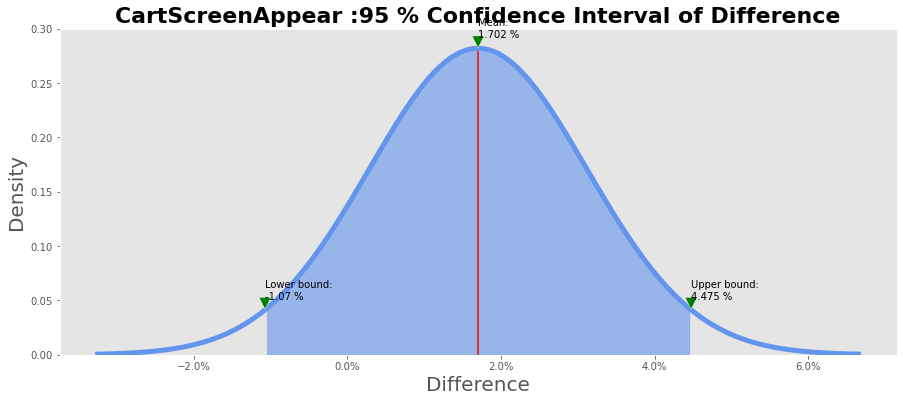

p-value of difference: 0.886
The difference is not statistically significant


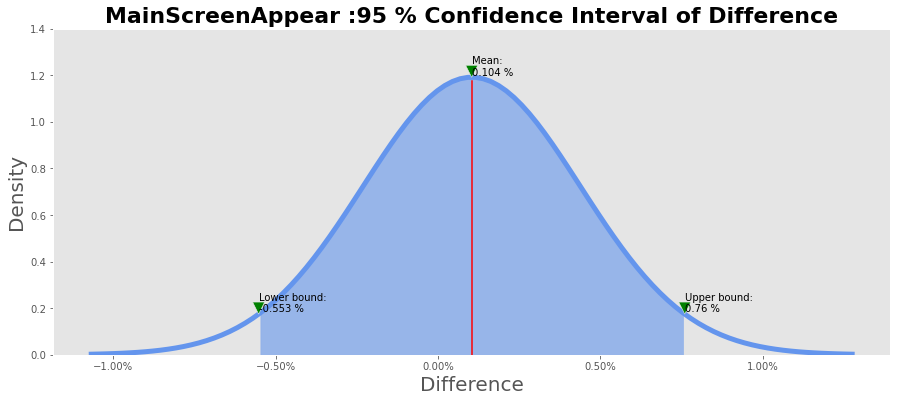

p-value of difference: 0.621
The difference is not statistically significant


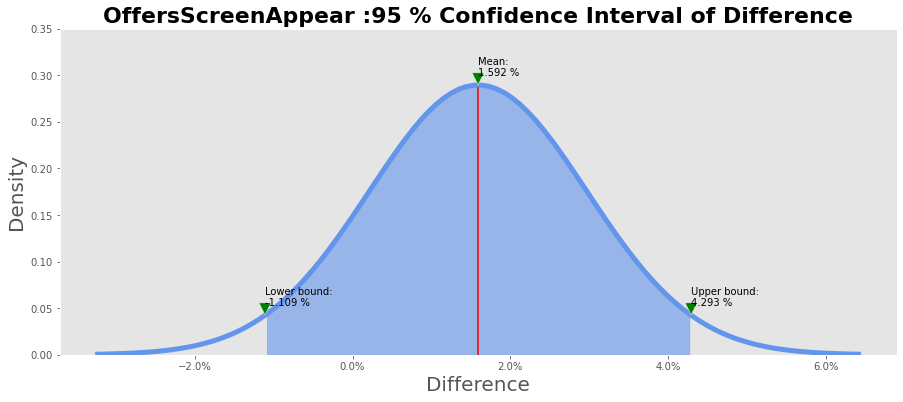

p-value of difference: 0.876
The difference is not statistically significant


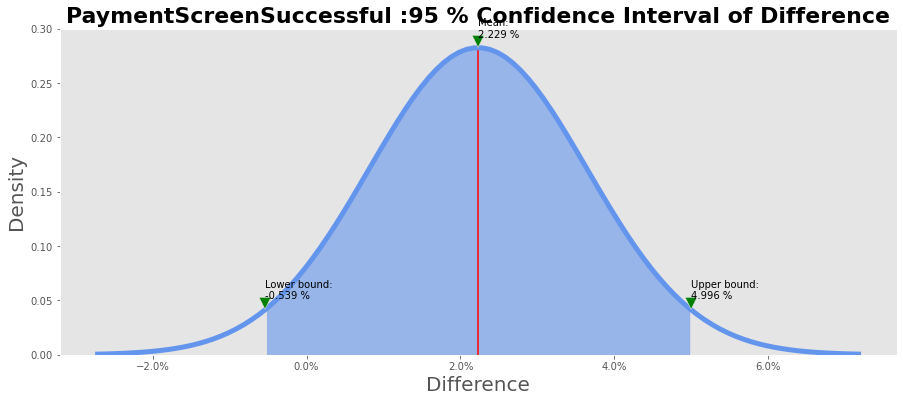

p-value of difference: 0.943
The difference is not statistically significant


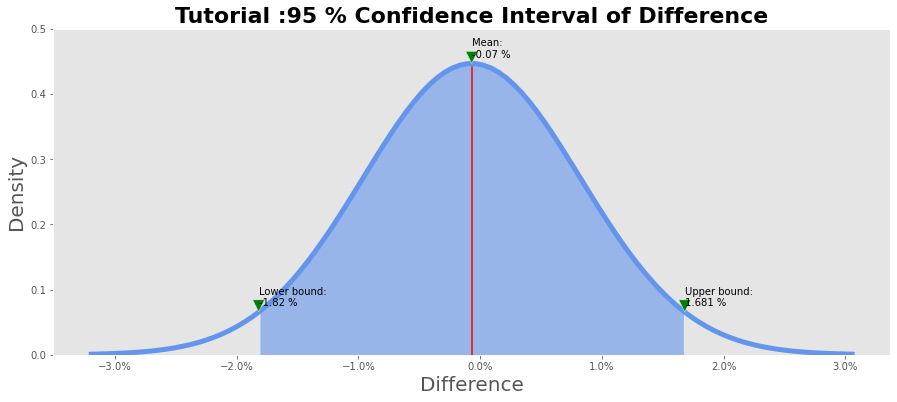

p-value of difference: 0.469
The difference is not statistically significant


In [128]:
for i in range(0,len(A1)):
    confidence(A1['count'][i],A2['count'][i], A1['total_users'][i], A2['total_users'][i],A1['event_name'][i], 'cornflowerblue', 5)

The difference between the groups is not statistically significant for any of the events. Thus, we can confidently start our AB tests. 

#### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

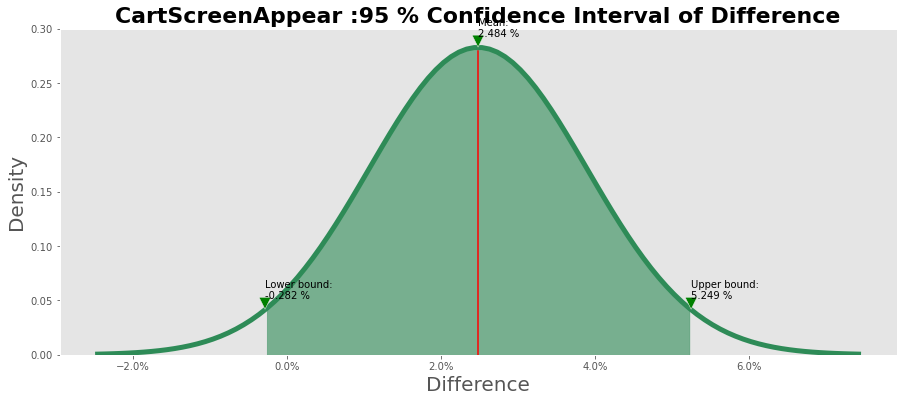

p-value of difference: 0.961
The difference is not statistically significant


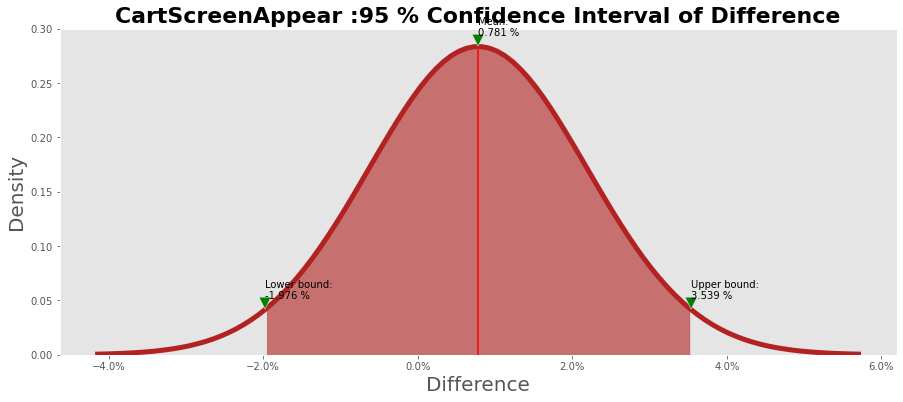

p-value of difference: 0.711
The difference is not statistically significant


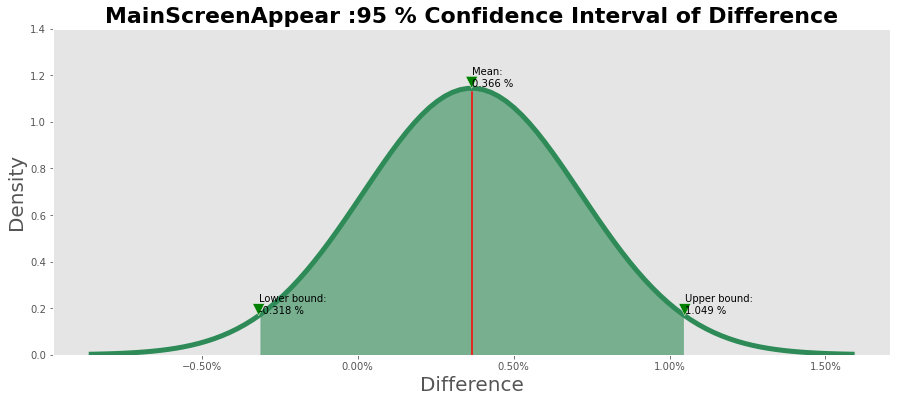

p-value of difference: 0.853
The difference is not statistically significant


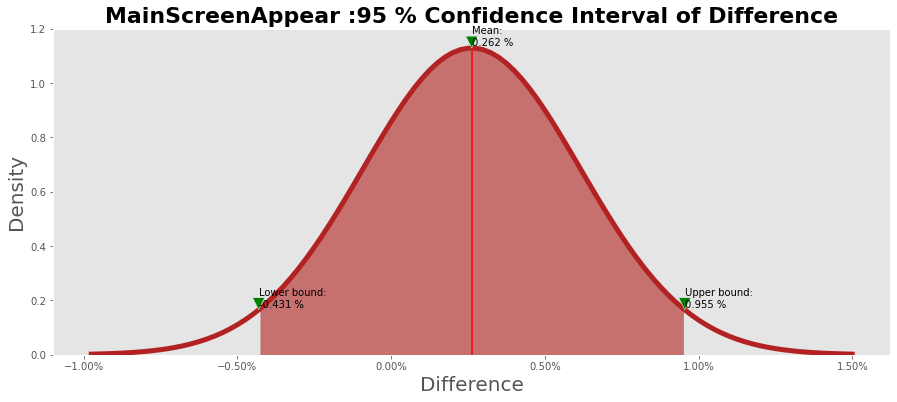

p-value of difference: 0.771
The difference is not statistically significant


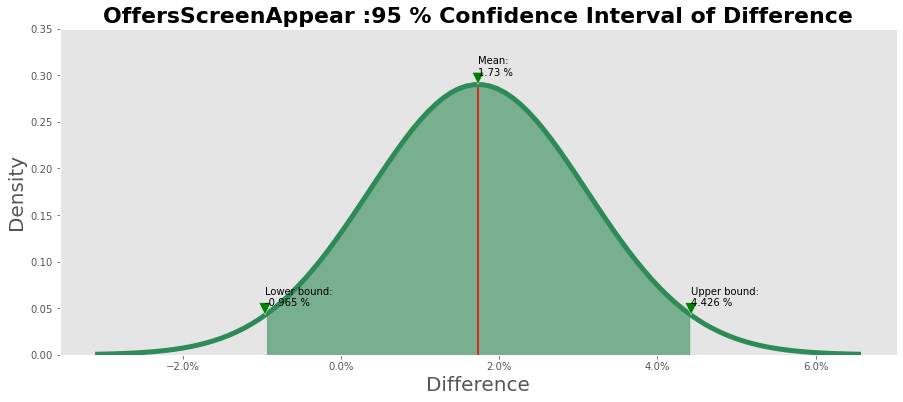

p-value of difference: 0.896
The difference is not statistically significant


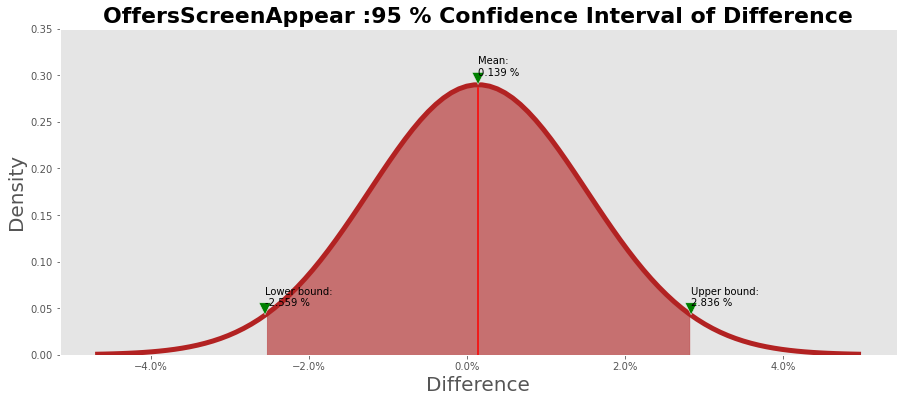

p-value of difference: 0.540
The difference is not statistically significant


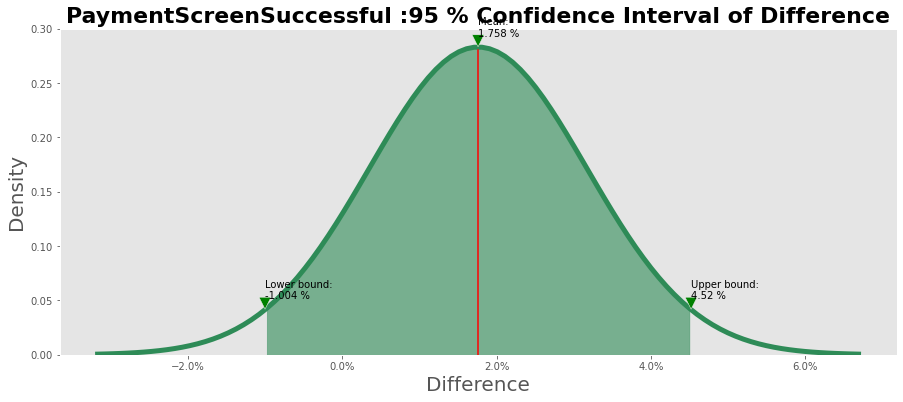

p-value of difference: 0.894
The difference is not statistically significant


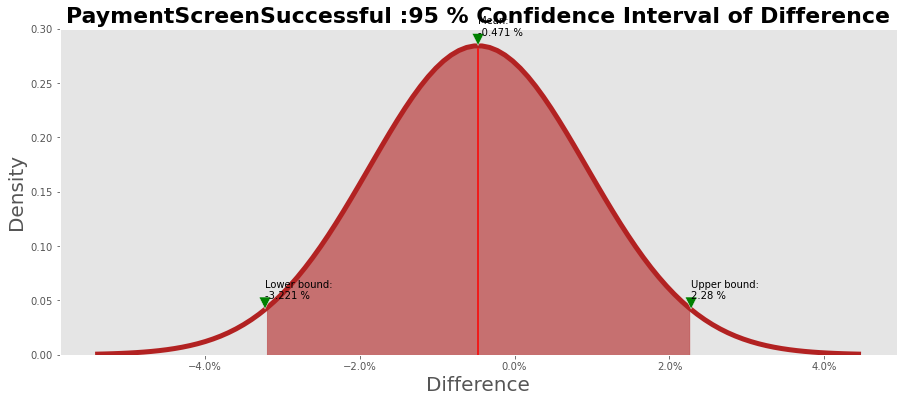

p-value of difference: 0.369
The difference is not statistically significant


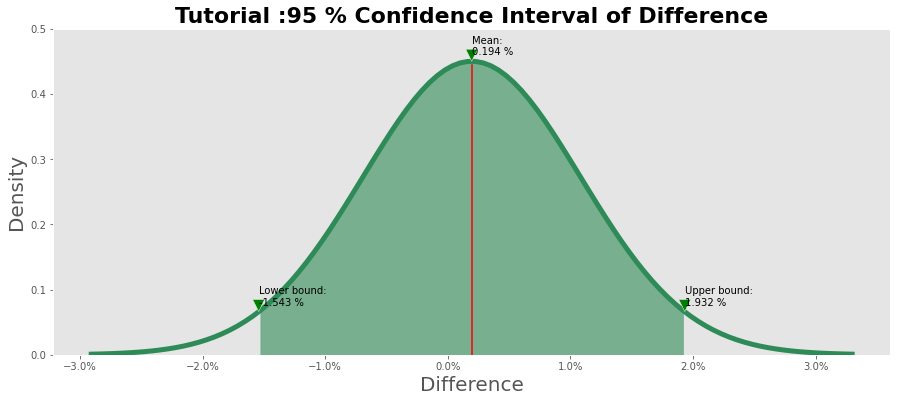

p-value of difference: 0.587
The difference is not statistically significant


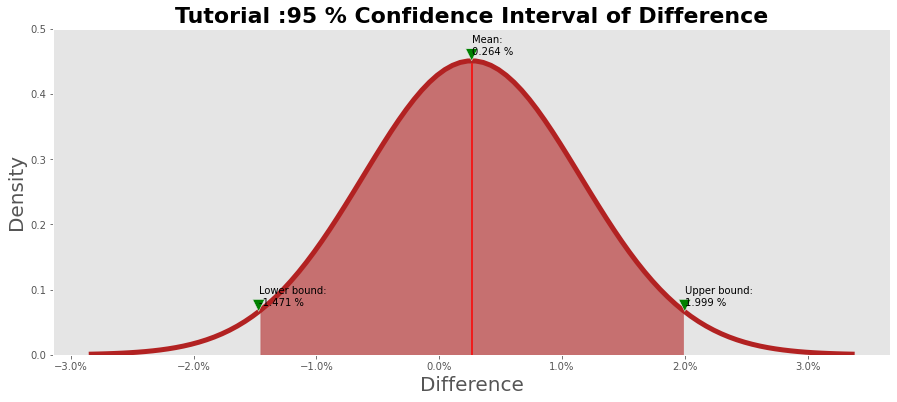

p-value of difference: 0.617
The difference is not statistically significant


In [129]:
for i in range(0,len(A1)):
    confidence(A1['count'][i],B['count'][i], A1['total_users'][i], B['total_users'][i],A1['event_name'][i], 'seagreen',10)
    confidence(A2['count'][i],B['count'][i], A2['total_users'][i], B['total_users'][i],A2['event_name'][i], 'firebrick',10)

In [143]:
A_comb= A1[['count','total_users']]+A2[['count','total_users']] 
A_comb['event_name']= A1.event_name

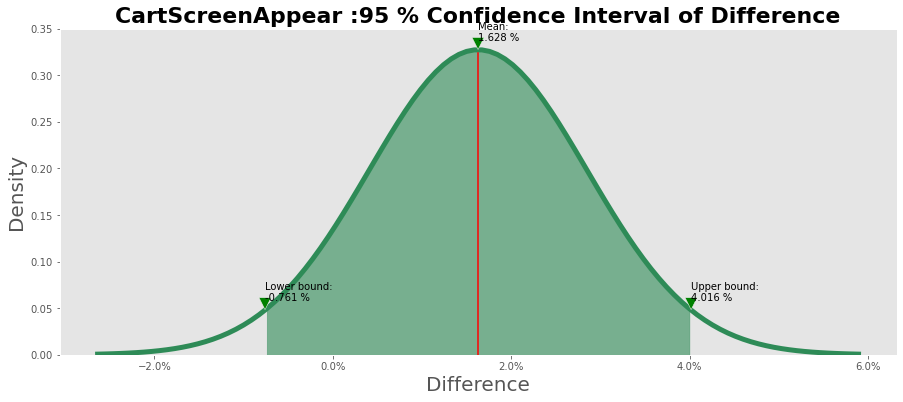

p-value of difference: 0.909
The difference is not statistically significant


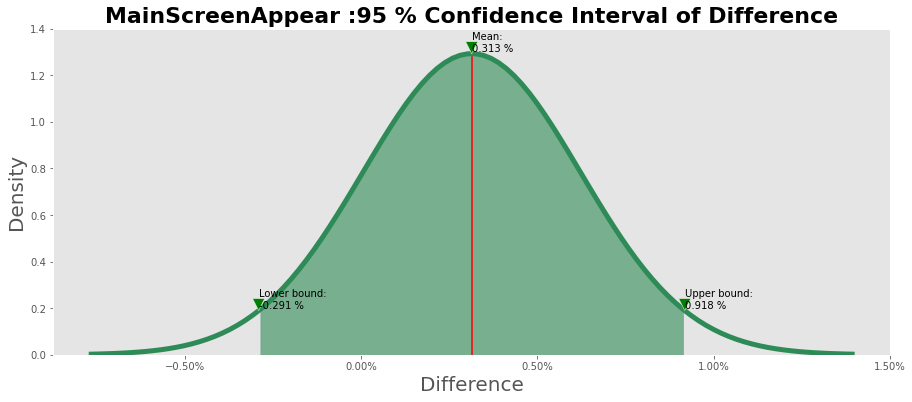

p-value of difference: 0.845
The difference is not statistically significant


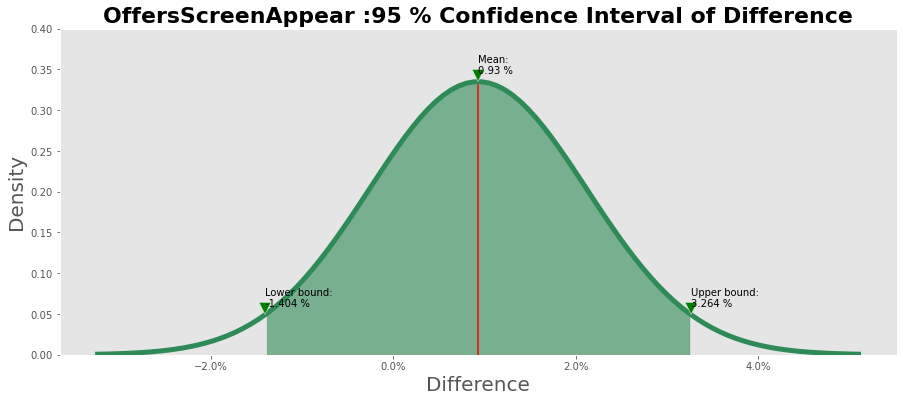

p-value of difference: 0.783
The difference is not statistically significant


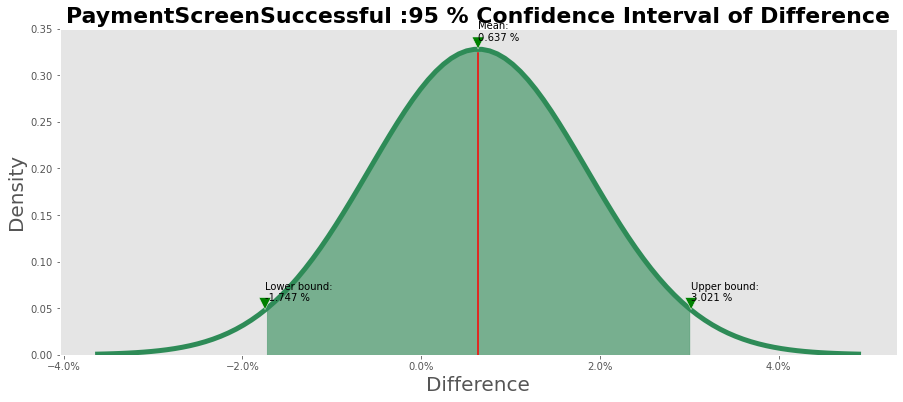

p-value of difference: 0.700
The difference is not statistically significant


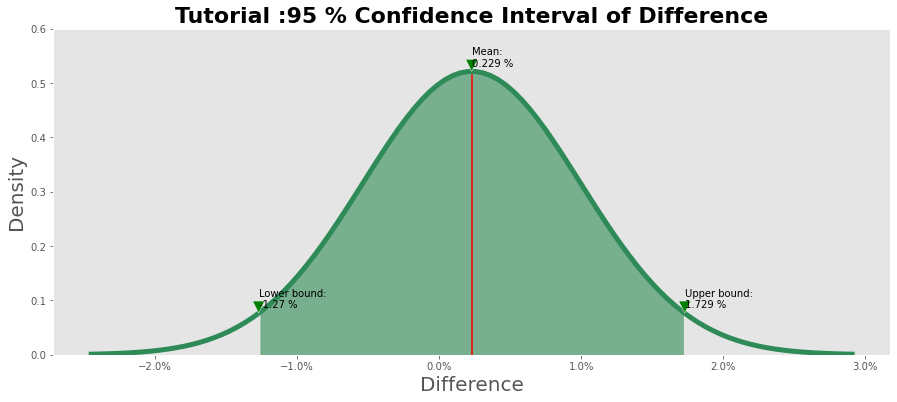

p-value of difference: 0.618
The difference is not statistically significant


In [141]:
for i in range(0,len(A1)):
    confidence(A_comb['count'][i],B['count'][i], A_comb['total_users'][i], B['total_users'][i],A_comb['event_name'][i], 'seagreen',10)

None of all tested configurations came even close at proving a significant difference in proportions. We can conclude from these tests that altered fonts will not add value to our business. 

# Conclusion 

This report presented an analysis of our websites sales funnel and tested whether altered fonts can increase conversion at each stage of the funnel. 

The AB test was conducted using two control groups. The results show that at no stage altered fonts led to a signifcant difference in conversions. We have enough evidence to conclude that this modification is not worth the effort. 

However, the enquiry revealed a potentially promising avenue for future research:  
It appears that most users already churn after visiting the main screen. As soon as they see the product page, they proceed to payment in almost 80% of all cases. Thus, we should seriously consider to place more products on the main page as this might increase conversion. 